In [1]:
def get_auc_list(X, y, clf, print_score=True):
    predictions = list()
    scores = list()
    for i, tree in enumerate(clf.estimators_):
        predictions.append(tree.predict_proba(X))
        rf_prediction = mean(predictions, axis=0)
        scores.append(log_loss(y, rf_prediction))
    if print_score:
        print 'Last score', scores[-1]
    return scores

def plot_auc_graph(clf, X_train, X_test, y_train, y_test, prefix, print_train=True):
    clf.fit(X_train, y_train)
    train_aucs = get_auc_list(X_train, y_train, clf, print_train)
    test_aucs = get_auc_list(X_test, y_test, clf, True)
    if print_train:
        plot(train_aucs, label=prefix + ' train set')
    plot(test_aucs, label=prefix + ' test set')
    xlabel('n_estimators')
    ylabel('log_loss')
    legend(loc=1)
    
def plot_features_random_forest(clf):
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
#     print("Feature ranking:")

    # for f in range(X_train.shape[1]):
    #     print(\"%d. feature %d (%f)\" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure(figsize=(8,4))
    plt.title("Feature importances")
    plt.bar(range(X_train.shape[1]), importances[indices])
    plt.xticks(range(X_train.shape[1]), indices)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()
    
def plot_quality(grid_searcher, param_name):
    means = []
    stds = []
    for elem in grid_searcher.grid_scores_:
        means.append(mean(elem.cv_validation_scores))
        stds.append(sqrt(var(elem.cv_validation_scores)))
    means = array(means)
    stds = array(stds)
    
    params = grid_searcher.param_grid
    
    figure(figsize=(8, 6))
    plot(params[param_name], means)
    fill_between(params[param_name], \
                 means + stds, means - stds, alpha = 0.3, facecolor='blue')
    xlabel(param_name)
    ylabel('LOG LOSS')

# Пояснение модели
Традиционно данные были разбиты на train, test, validation. Потом были всяческие жалкие попытки обучить приличный случайный лес. После 100500 раза были опробованы 5 линейных моделей, которые по отдельности давали результат значительно хуже RandomForest, по после усреднения были сравнимы качество было сравнимо с RandomForest. После такого было решено обучить какое-то кол-во моделей, а в качестве ответа предоставить среднее значение.

Ну и ниже идет просто обучение различных моделей, порой они очень похожи, порой они бердовые и не объяснимы.

А вообще, похоже на какую-то очень плохую модель, которая выстрелила при удачных random_state

# WARNING. БЫДЛОКОД detected
<img src="http://cs622927.vk.me/v622927463/3239e/idTHUIWcuZk.jpg"/>

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestClassifier

from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.linear_model import LogisticRegression as SAG
from sklearn.cross_validation import KFold

from sklearn.feature_selection import SelectFromModel
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from sklearn.ensemble import ExtraTreesClassifier as ETC
from sklearn.preprocessing import StandardScaler
from sklearn.svm  import SVC 
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVR

In [5]:
import seaborn as sns

Функция котороая разбивает train на части, потом предсказывает одну часть по осатльным. По итогу получим получаем дополнительный признак - выход конкретной модели. Эта идеи была высказана на семинаре 12 апреля

In [6]:
# %%time
def getCVOutFromModel(inputClf, X, y, colName='Prediction', preTrans=None, nFolds=3, randomState=0, needScores=False):
    kf_total = KFold(X.shape[0], n_folds=nFolds, shuffle=True, random_state=randomState)
    
    yPred = pd.DataFrame()
    scores = []
    for train_index, test_index in kf_total:
        clf = inputClf;
        matrXFit = preTrans.transform(X.iloc[train_index, :]) if preTrans else X.iloc[train_index, :]
        yFit = y[train_index]
        matrXTest = preTrans.transform(X.iloc[test_index, :]) if preTrans else X.iloc[test_index, :]
        yTest = y[test_index]

        clf.fit(matrXFit, yFit)

        pred = clf.predict_proba(matrXTest)
        scores.append(log_loss(yTest, pred))
        yPred = yPred.append(pd.DataFrame(pred[:,1], index=X_train.iloc[test_index, :].index))
    
    yPred.columns = [colName]
    
    if needScores:
        return yPred, scores
    else:
        return yPred

In [7]:
# глобальные переменные.
GLOBAL_RANDOM_CV = 75441
GLOBAL_TRAIN_TEST_VALID_SPLIT = 643423
GLOBAL_RND_SELECT_MODEL = 5432543
GLOBAL_RND_MODEL = 6534245

GLOBAL_NFOLD = 13

In [8]:
Xtrain = pd.read_csv('X.train.csv')
Xtest = pd.read_csv('X.test.csv')

ytrain = pd.read_csv('y.train.csv')['label']

Xfull = pd.concat([Xtrain, Xtest], axis=0)
# есть мнение что признак 'V48' имеет значение 0 и NA, причем NA не дает никакой информации
Xfull.drop('V48', axis=1, inplace=True)
Xfull.fillna(-9999, inplace=True)

ytrain = ytrain.as_matrix()

In [9]:
X_train = Xfull.iloc[:ytrain.shape[0], :]
X_sub = Xfull.iloc[ytrain.shape[0]:, :]
print X_train.shape, X_sub.shape
print Xtrain.shape, Xtest.shape

(4099, 1329) (1366, 1329)
(4099, 1330) (1366, 1330)


Тут стоит отметить, что в ходе исследований разбиение было 60/20/20 (train/valid/test). И поэтому качества моделей на выборках test и valid были весьма адекватными. После выбора итоговой модели разбиение превратилось в 95/2.5/2.5 (train/valid/test), чтобы увеличить обучающую выборку.

In [10]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, ytrain, test_size=0.05,
                                                    random_state=GLOBAL_TRAIN_TEST_VALID_SPLIT)
X_test, X_valid, y_test, y_valid  = train_test_split(X_test, y_test, test_size=0.5,
                                                     random_state=GLOBAL_TRAIN_TEST_VALID_SPLIT)
print sum(y_train)
print sum(y_valid)
print sum(y_test)

321
10
12


featureX_train - тут храним выходы функции getCVOutFromModel от разных моделей.

In [11]:
featureX_train = pd.DataFrame(index=X_train.index)

### Модель 1-4
Случайные леса, только выбираем самые важные признаки.
1. RandomForest 'важные' признаки выбираются RandomForest
2. RandomForest 'важные' признаки выбираются ExtraTreesClassifier
3. ExtraTreesClassifier 'важные' признаки выбираются RandomForest
4. ExtraTreesClassifier 'важные' признаки выбираются ExtraTreesClassifier

In [12]:
selectModel_1 = SelectFromModel(RFC(n_estimators=800, criterion='entropy',
                                    random_state=GLOBAL_RND_SELECT_MODEL))
selectModel_1.fit(X_train, y_train);

selectModel_2 = SelectFromModel(ETC(n_estimators=800, criterion='entropy',
                                    random_state=GLOBAL_RND_SELECT_MODEL))
selectModel_2.fit(X_train, y_train);

In [13]:
model1 = RFC(n_estimators=2500, criterion='entropy', random_state=GLOBAL_RND_MODEL)
model2 = ETC(n_estimators=2500, criterion='entropy', random_state=GLOBAL_RND_MODEL)

In [14]:
%%time
y1, sc1 = getCVOutFromModel(model1, X_train, y_train, preTrans=selectModel_1,
                            nFolds=GLOBAL_NFOLD, randomState=GLOBAL_RANDOM_CV, needScores=True)
y2, sc2 = getCVOutFromModel(model1, X_train, y_train, preTrans=selectModel_2,
                            nFolds=GLOBAL_NFOLD, randomState=GLOBAL_RANDOM_CV, needScores=True)
y3, sc3 = getCVOutFromModel(model2, X_train, y_train, preTrans=selectModel_1,
                            nFolds=GLOBAL_NFOLD, randomState=GLOBAL_RANDOM_CV, needScores=True)
y4, sc4 = getCVOutFromModel(model2, X_train, y_train, preTrans=selectModel_2,
                            nFolds=GLOBAL_NFOLD, randomState=GLOBAL_RANDOM_CV, needScores=True)

CPU times: user 29min 45s, sys: 2 s, total: 29min 47s
Wall time: 29min 47s


In [15]:
print sc1
print sc2
print sc3
print sc4

[0.19717266403563266, 0.22017340207599317, 0.25580726248706726, 0.26050159533880207, 0.14680525936048611, 0.20076601628624624, 0.28331507881307111, 0.1679456809126991, 0.20677161417424614, 0.17673370091404106, 0.18350044033067728, 0.20619545182908061, 0.22844683971373056]
[0.20330133419378019, 0.21667248277697884, 0.24622645943114208, 0.2579091628091526, 0.14927124214564752, 0.20063516546614285, 0.2830740942954979, 0.16571819528913861, 0.20133735029115951, 0.17802554096777257, 0.1803895237475259, 0.20984969102472759, 0.2192210665592591]
[0.19272566686914705, 0.22432738601201563, 0.25430867864453888, 0.25302738000609132, 0.14090683098618975, 0.18140123197459265, 0.28224204896234711, 0.16896131850319324, 0.21430854322291903, 0.17394927676489449, 0.1854672685606702, 0.20842394816517612, 0.21368083332425189]
[0.20778235628848635, 0.21327754465441898, 0.23990636812559757, 0.25174074436072186, 0.14800609118892238, 0.19602780049735191, 0.28025368831588643, 0.16541739899167579, 0.2027837168668

In [16]:
featureX_train['y1'] = y1
featureX_train['y2'] = y2
featureX_train['y3'] = y3
featureX_train['y4'] = y4

In [17]:
print selectModel_1.transform(X_valid).shape
print selectModel_1.transform(X_train).shape

(103, 220)
(3894, 220)


In [18]:
m1 = RFC(n_estimators=2500, criterion='entropy', random_state=GLOBAL_RND_MODEL) #selectModel_1
m2 = RFC(n_estimators=2500, criterion='entropy', random_state=GLOBAL_RND_MODEL) #selectModel_2
m3 = ETC(n_estimators=2500, criterion='entropy', random_state=GLOBAL_RND_MODEL) #selectModel_1
m4 = ETC(n_estimators=2500, criterion='entropy', random_state=GLOBAL_RND_MODEL) #selectModel_2

m1.fit(selectModel_1.transform(X_train), y_train)
m2.fit(selectModel_2.transform(X_train), y_train)
m3.fit(selectModel_1.transform(X_train), y_train)
m4.fit(selectModel_2.transform(X_train), y_train)

yv1 = m1.predict_proba(selectModel_1.transform(X_valid))
yv2 = m2.predict_proba(selectModel_2.transform(X_valid))
yv3 = m3.predict_proba(selectModel_1.transform(X_valid))
yv4 = m4.predict_proba(selectModel_2.transform(X_valid))

yt1 = m1.predict_proba(selectModel_1.transform(X_test))
yt2 = m2.predict_proba(selectModel_2.transform(X_test))
yt3 = m3.predict_proba(selectModel_1.transform(X_test))
yt4 = m4.predict_proba(selectModel_2.transform(X_test))

featureX_valid = pd.DataFrame(index=X_valid.index)
featureX_valid['y1'] = yv1[:, 1]
featureX_valid['y2'] = yv2[:, 1]
featureX_valid['y3'] = yv3[:, 1]
featureX_valid['y4'] = yv4[:, 1]

featureX_test = pd.DataFrame(index=X_test.index)
featureX_test['y1'] = yt1[:, 1]
featureX_test['y2'] = yt2[:, 1]
featureX_test['y3'] = yt3[:, 1]
featureX_test['y4'] = yt4[:, 1]

In [19]:
ys1 = m1.predict_proba(selectModel_1.transform(X_sub))
ys2 = m2.predict_proba(selectModel_2.transform(X_sub))
ys3 = m3.predict_proba(selectModel_1.transform(X_sub))
ys4 = m4.predict_proba(selectModel_2.transform(X_sub))

featureX_sub = pd.DataFrame(index=X_sub.index)
featureX_sub['y1'] = ys1[:, 1]
featureX_sub['y2'] = ys2[:, 1]
featureX_sub['y3'] = ys3[:, 1]
featureX_sub['y4'] = ys4[:, 1]

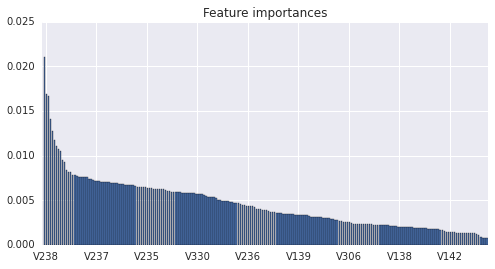

In [20]:
importances = m1.feature_importances_
std = np.std([tree.feature_importances_ for tree in m1.estimators_],
         axis=0)
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,4))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices])
plt.xticks(arange(1, len(indices), 25), X_valid.columns[selectModel_1.get_support()][indices])
plt.xlim([-1, len(indices)])
plt.show()

In [21]:
print log_loss(y_valid, np.array([1-featureX_valid.mean(axis=1), featureX_valid.mean(axis=1)]).T)
print log_loss(y_test, np.array([1-featureX_test.mean(axis=1), featureX_test.mean(axis=1)]).T)
print log_loss(y_train, np.array([1-featureX_train.mean(axis=1), featureX_train.mean(axis=1)]).T)

0.231460512334
0.259135779932
0.206860742967


## Linear Models 5-8
Модели обучались только на не категориальных признаках. Параметры были подобраны GridSearchCV несколько днями ранеее
1. SVC
2. KNN
3. LogisticRegression L1 Regularization
4. LogisticRegression L2 Regularization
5. SGDClassifier - not using

In [22]:
Meta = pd.read_csv('MetaData.csv', index_col=0)
notCategoryFeatures = Meta.index[Meta.Column_Type != 'Category']

In [23]:
preProcSTD = StandardScaler()
preProcSTD.fit(X_train[notCategoryFeatures])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [24]:
svmModel = SVC(probability=True, random_state=GLOBAL_RND_MODEL, C=0.351)
knnModel = KNeighborsClassifier(weights='distance', n_neighbors=150)
logL1Model = LogisticRegression(penalty='l1', C=0.15, random_state=GLOBAL_RND_MODEL)
logL2Model = LogisticRegression(penalty='l2', C=0.15, random_state=GLOBAL_RND_MODEL)
sgdModel = SGDClassifier(random_state=GLOBAL_RND_MODEL, loss='log', alpha=0.0288)

In [25]:
%%time
y5, sc5 = getCVOutFromModel(svmModel, X_train[notCategoryFeatures], y_train, preTrans=preProcSTD,
                            nFolds=GLOBAL_NFOLD,
                            randomState=GLOBAL_RANDOM_CV, needScores=True)
y6, sc6 = getCVOutFromModel(knnModel, X_train[notCategoryFeatures], y_train, preTrans=preProcSTD,
                            nFolds=GLOBAL_NFOLD,
                            randomState=GLOBAL_RANDOM_CV, needScores=True)
y7, sc7 = getCVOutFromModel(logL1Model, X_train[notCategoryFeatures], y_train, preTrans=preProcSTD,
                            nFolds=GLOBAL_NFOLD,
                            randomState=GLOBAL_RANDOM_CV, needScores=True)
y8, sc8 = getCVOutFromModel(logL2Model, X_train[notCategoryFeatures], y_train, preTrans=preProcSTD,
                            nFolds=GLOBAL_NFOLD,
                            randomState=GLOBAL_RANDOM_CV, needScores=True)
y9, sc9 = getCVOutFromModel(sgdModel, X_train[notCategoryFeatures], y_train, preTrans=preProcSTD,
                            nFolds=GLOBAL_NFOLD,
                            randomState=GLOBAL_RANDOM_CV, needScores=True)
print sc5
print sc6
print sc7
print sc8
print sc9

[0.23887330248238087, 0.22791041595479963, 0.29284393234707418, 0.28918129345379295, 0.18556978485098538, 0.24732806532684554, 0.32320455761198275, 0.19505769785796895, 0.22977203484394707, 0.22155411755910909, 0.21436049659242462, 0.2617632712882792, 0.26261253949269714]
[0.22838146457365496, 0.34120263537504303, 0.31107586382128516, 0.30689659210902209, 0.17807865662928818, 0.24377832287958312, 0.31864007846400888, 0.17378232449077033, 0.23490016060708505, 0.22773720797335606, 0.19916477524314535, 0.23526879195617445, 0.29164993012937979]
[0.21688689084525076, 0.22287872162502084, 0.2689851684553875, 0.28642723317186863, 0.15706697272177722, 0.22464634336451036, 0.31004949623962241, 0.16772297507946668, 0.21233486769365562, 0.18643605169025246, 0.19022337526356664, 0.22971949921478485, 0.24143816937908913]
[0.23793093285479761, 0.2255514731443328, 0.27530773315966423, 0.28939174782875532, 0.15794937401706283, 0.23988561870615907, 0.31282911862735413, 0.17420637718047746, 0.2099781797

In [26]:
featureX_train['y5'] = y5
featureX_train['y6'] = y6
featureX_train['y7'] = y7
featureX_train['y8'] = y8
# featureX_train['y9'] = y9

In [27]:
svmModel = SVC(probability=True, random_state=GLOBAL_RND_MODEL, C=0.351)
knnModel = KNeighborsClassifier(weights='distance', n_neighbors=150)
logL1Model = LogisticRegression(penalty='l1', C=0.15, random_state=GLOBAL_RND_MODEL)
logL2Model = LogisticRegression(penalty='l2', C=0.15, random_state=GLOBAL_RND_MODEL)
# sgdModel = SGDClassifier(random_state=514, loss='log', alpha=0.0288)

svmModel.fit(preProcSTD.transform(X_train[notCategoryFeatures]), y_train)
knnModel.fit(preProcSTD.transform(X_train[notCategoryFeatures]), y_train)
logL1Model.fit(preProcSTD.transform(X_train[notCategoryFeatures]), y_train)
logL2Model.fit(preProcSTD.transform(X_train[notCategoryFeatures]), y_train)

yv5 = svmModel.predict_proba(preProcSTD.transform(X_valid[notCategoryFeatures]))
yv6 = knnModel.predict_proba(preProcSTD.transform(X_valid[notCategoryFeatures]))
yv7 = logL1Model.predict_proba(preProcSTD.transform(X_valid[notCategoryFeatures]))
yv8 = logL2Model.predict_proba(preProcSTD.transform(X_valid[notCategoryFeatures]))

yt5 = svmModel.predict_proba(preProcSTD.transform(X_test[notCategoryFeatures]))
yt6 = knnModel.predict_proba(preProcSTD.transform(X_test[notCategoryFeatures]))
yt7 = logL1Model.predict_proba(preProcSTD.transform(X_test[notCategoryFeatures]))
yt8 = logL2Model.predict_proba(preProcSTD.transform(X_test[notCategoryFeatures]))

# featureX_valid = pd.DataFrame(index=X_valid.index)
featureX_valid['y5'] = yv5[:, 1]
featureX_valid['y6'] = yv6[:, 1]
featureX_valid['y7'] = yv7[:, 1]
featureX_valid['y8'] = yv8[:, 1]

# featureX_test = pd.DataFrame(index=X_test.index)
featureX_test['y5'] = yt5[:, 1]
featureX_test['y6'] = yt6[:, 1]
featureX_test['y7'] = yt7[:, 1]
featureX_test['y8'] = yt8[:, 1]

In [28]:
ys5 = svmModel.predict_proba(preProcSTD.transform(X_sub[notCategoryFeatures]))
ys6 = knnModel.predict_proba(preProcSTD.transform(X_sub[notCategoryFeatures]))
ys7 = logL1Model.predict_proba(preProcSTD.transform(X_sub[notCategoryFeatures]))
ys8 = logL2Model.predict_proba(preProcSTD.transform(X_sub[notCategoryFeatures]))

# featureX_valid = pd.DataFrame(index=X_valid.index)
featureX_sub['y5'] = ys5[:, 1]
featureX_sub['y6'] = ys6[:, 1]
featureX_sub['y7'] = ys7[:, 1]
featureX_sub['y8'] = ys8[:, 1]

In [29]:
# featureX_test.drop('y_', axis=1, inplace=True)

In [30]:
print log_loss(y_valid, np.array([1-featureX_valid.mean(axis=1), featureX_valid.mean(axis=1)]).T)
print log_loss(y_test, np.array([1-featureX_test.mean(axis=1), featureX_test.mean(axis=1)]).T)
print log_loss(y_train, np.array([1-featureX_train.mean(axis=1), featureX_train.mean(axis=1)]).T)
# 0.207193396576
# 0.218516409148
# 0.21697000027

0.239217751047
0.263669399234
0.212848406214


# Первая попытка обобщить полученные данные

In [31]:
X_train_ = pd.concat([X_train, featureX_train], axis=1)

In [32]:
s = SelectFromModel(RFC(n_estimators=800, criterion='entropy', random_state=GLOBAL_RND_SELECT_MODEL))
s.fit(X_train_, y_train);

In [33]:
y_, sc_ = getCVOutFromModel(RFC(n_estimators=2500, criterion='entropy', random_state=GLOBAL_RND_MODEL),
                            X_train_, y_train, preTrans=s,
                            nFolds=7, randomState=GLOBAL_RANDOM_CV, needScores=True)

print sc_

[0.1907478665913625, 0.271313451732629, 0.18344890965601293, 0.24198346133960713, 0.18690494553749776, 0.18528560678865202, 0.21630595105514619]


In [34]:
rf = RFC(n_estimators=2500, criterion='entropy', random_state=GLOBAL_RND_MODEL)
rf.fit(s.transform(X_train_), y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2500, n_jobs=1,
            oob_score=False, random_state=6534245, verbose=0,
            warm_start=False)

In [35]:
X_test_ = pd.concat([X_test, featureX_test], axis=1)
print log_loss(y_test, rf.predict_proba(s.transform(X_test_)))

X_valid_ = pd.concat([X_valid, featureX_valid], axis=1)
print log_loss(y_valid, rf.predict_proba(s.transform(X_valid_)))

# mean forests
# 0.218516409148
# 0.207193396576

# RFC 25000
# 0.217318170197
# 0.205574898974

0.253204238198
0.238914461842


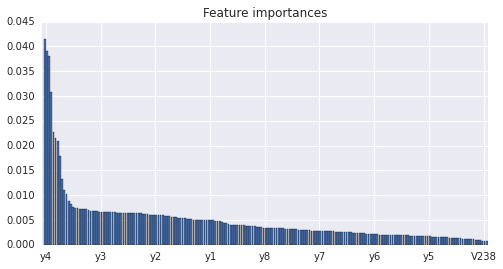

In [36]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
         axis=0)
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,4))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices])
plt.xticks(arange(1, len(indices), 25), X_valid_.columns[s.get_support()][indices])
plt.xlim([-1, len(indices)])
plt.show()

### Обертка для getCVOutFromModel

In [37]:
def getCVModel_fit_transform(inputClf, X, y,
                              validData, testData,
                              colName='Prediction', preTrans=None, nFolds=3, randomState=0,
                              needScores=False):
    clf = inputClf
    if needScores:
        y_, sc_ = getCVOutFromModel(clf, X, y, colName=colName, preTrans=preTrans,
                                nFolds=nFolds, randomState=randomState, needScores=needScores)
    else:
        y_ = getCVOutFromModel(clf, X, y, colName=colName, preTrans=preTrans,
                                nFolds=nFolds, randomState=randomState, needScores=needScores)

    Xfit_ = preTrans.transform(X) if preTrans else X
    clf.fit(Xfit_, y)

    Xvalid_ = preTrans.transform(validData) if preTrans else validData
    Xtest_ = preTrans.transform(testData) if preTrans else testData
    
    yv_ = clf.predict_proba(Xvalid_)
    yt_ = clf.predict_proba(Xtest_)
    
    if needScores:
        return y_, yv_, yt_, clf, sc_
    else:
        return y_, yv_, yt_, clf

# One hot encoder
9-я модель Обучаем RandomForest на данных после OneHotEncoder

In [38]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

allCategoryFeatures = Meta[Meta.Column_Type == 'Category'].index
allCategoryFeatures = allCategoryFeatures.drop('V48')

X_trainOne = X_train.copy()
X_validOne = X_valid.copy()
X_testOne = X_test.copy()
X_subOne = X_sub.copy()


X_trainOne['type'] = 'train'
X_validOne['type'] = 'valid'
X_testOne['type'] = 'test'
X_subOne['type'] = 'sub'

X_FULL = pd.concat([X_trainOne, X_validOne, X_testOne, X_subOne], axis=0)
toOnehot = np.abs(X_FULL[allCategoryFeatures].as_matrix())
onehotX = OneHotEncoder(sparse=False).fit_transform(toOnehot)

X_onehot = pd.concat([X_FULL, pd.DataFrame(onehotX, index=X_FULL.index)], axis=1)

X_trainOne = X_onehot[X_onehot.type == 'train'].drop('type', axis=1)
X_validOne = X_onehot[X_onehot.type == 'valid'].drop('type', axis=1)
X_testOne = X_onehot[X_onehot.type == 'test'].drop('type', axis=1)
X_subOne = X_onehot[X_onehot.type == 'sub'].drop('type', axis=1)


clf_onehot = RFC(n_estimators=600, criterion='entropy', random_state=GLOBAL_RND_SELECT_MODEL)
sfm_rf_onehot = SelectFromModel(clf_onehot)
sfm_rf_onehot.fit(X_trainOne, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=5432543, verbose=0,
            warm_start=False),
        prefit=False, threshold=None)

In [39]:
y_, yv_, yt_, clf, sc_ = getCVModel_fit_transform(
                            RFC(n_estimators=1600, criterion='entropy', random_state=GLOBAL_RND_MODEL),
                            X=X_trainOne,
                            y=y_train,
                            validData=X_validOne,
                            testData=X_testOne,
                            preTrans=sfm_rf_onehot, 
                            nFolds=GLOBAL_NFOLD, randomState=GLOBAL_RANDOM_CV, needScores=True)

print sc_
print log_loss(y_valid, yv_)
print log_loss(y_test, yt_)

[0.20401263543424983, 0.21891730913904392, 0.25053464916747209, 0.25705241694509889, 0.1497458451458204, 0.20634664791160937, 0.28804347460796376, 0.16988438507065459, 0.20787219242461799, 0.18303084733782685, 0.18394564027323235, 0.20834599719257729, 0.23172787323910973]
0.241222020365
0.260326840329


In [40]:
featureX_train['OneHot'] = y_
featureX_test['OneHot'] = yt_[:, 1]
featureX_valid['OneHot'] = yv_[:, 1]
featureX_sub['OneHot'] = clf.predict_proba(sfm_rf_onehot.transform( X_subOne))[:, 1]

## Counting
10-я модель. Заменяем категориальные признаки счетчиками.

In [41]:
def transform(X, y, col, kfold=5, random_state=512):
    dt = pd.DataFrame(index=X.index)
    dt['y'] = y
    dt[col] = X[col]
    
    R = pd.DataFrame(columns=[col])
    
    if(kfold > 1):
        kf = KFold(n=dt.shape[0], n_folds=kfold, shuffle=True, random_state=random_state)
    
        for train_index, test_index in kf:
            tr_index = dt.index[train_index]
            ts_index = dt.index[test_index]
            gp = dt.ix[tr_index,:].groupby(col)
            R = pd.concat([X.ix[ts_index, col].replace(gp.mean()['y'].to_dict()), R], axis=0)
        
        return R[0]
    
def fit(X, y, col):
    dt = X.copy()
    dt['y'] = y
    gp = dt.groupby(col)
    return gp.mean()['y']

In [42]:
mostImpotence = X_valid.columns[selectModel_1.get_support()][indices]
# mostImpotence

In [43]:
X_trainCount = X_train.copy()
X_validCount = X_valid.copy()
X_testCount = X_test.copy()
X_subCount = X_sub.copy()

In [44]:
%%time
A = Meta.Column_Type #[mostImpotence]
mostImpCategoryFeatures = A[A == 'Category'].index
mostImpCategoryFeatures = mostImpCategoryFeatures.drop('V48')

for col in mostImpCategoryFeatures:
    X_trainCount[col + 'trans'] = transform(X_trainCount, y_train, col=col,
                                            kfold=GLOBAL_NFOLD, random_state=GLOBAL_RANDOM_CV)

for col in mostImpCategoryFeatures:
    g = fit(X_trainCount, y_train, col=col)
    X_validCount[col + 'trans'] = X_validCount[col].replace(g)
    X_testCount[col + 'trans'] = X_testCount[col].replace(g)
    X_subCount[col + 'trans'] = X_subCount[col].replace(g)

CPU times: user 6min 42s, sys: 1min 15s, total: 7min 57s
Wall time: 7min 57s


In [45]:
sfm_rf_count = SelectFromModel(RFC(n_estimators=600, criterion='entropy', random_state=GLOBAL_RND_SELECT_MODEL))
sfm_rf_count.fit(X_trainCount, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=5432543, verbose=0,
            warm_start=False),
        prefit=False, threshold=None)

In [46]:
y_, yv_, yt_, clf, sc_ = getCVModel_fit_transform(
                            RFC(n_estimators=1600, criterion='entropy', random_state=GLOBAL_RND_MODEL),
                            X=X_trainCount,
                            y=y_train,
                            validData=X_validCount,
                            testData=X_testCount,
                            preTrans=sfm_rf_count, 
                            nFolds=GLOBAL_NFOLD, randomState=GLOBAL_RANDOM_CV, needScores=True)

print sc_
print log_loss(y_valid, yv_)
print log_loss(y_test, yt_)

# 0.18625053974
# 0.237523654944

[0.20342261190467487, 0.21556472906284033, 0.24671144321497215, 0.26343570831755658, 0.14620140448498836, 0.20260329741129618, 0.28400498109408262, 0.15875017745964662, 0.20435201763399771, 0.18127071594055014, 0.17570684454014396, 0.20520438209021136, 0.23539243657444112]
0.236159597121
0.276549691171


In [47]:
X_validCount.shape

(103, 2509)

In [48]:
featureX_train['Count'] = y_
featureX_test['Count'] = yt_[:, 1]
featureX_valid['Count'] = yv_[:, 1]

In [49]:
featureX_sub['Count'] = clf.predict_proba(sfm_rf_count.transform(X_subCount))[:, 1]

## Выкидываем некоторые признаки
11-я модель. Выкидываем признаки, которые с низкой дисперсией. Потом обучаем RandomForest

In [50]:
nzvFeatures = ["V3", "V14", "V18", "V20", "V26", "V27", "V45", "V46", "V47", "V49",
               "V50", "V51", "V56", "V58", "V59", "V60", "V61", "V62", "V65", "V66", 
                "V73", "V90", "V94", "V96", "V98", "V153", "V196", "V202", "V347", "V357",
               "V380", "V411", "V439", "V458", "V482", "V483", "V504", "V519", "V566",
                 "V581", "V583", "V601", "V602", "V603", "V604", "V607", "V637", "V667",
               "V670", "V671", "V675", "V698", "V723", "V773", "V781", "V801", "V817", 
                 "V834", "V840", "V841", "V849", "V887" , "V920", "V921", "V953", "V986", 
               "V987", "V988", "V1012", "V1016", "V1042", "V1047", "V1069", "V1070", 
                 "V1071", "V1114", "V1170", "V1208", "V1209", "V1226", "V1245", "V1271", "V1294", "V1329"]

In [51]:
X_trainDROP = X_train.drop(nzvFeatures, axis=1)
X_validDROP = X_valid.drop(nzvFeatures, axis=1)
X_testDROP = X_test.drop(nzvFeatures, axis=1)
X_subDROP  = X_sub.drop(nzvFeatures, axis=1)

In [52]:
%%time
sfm_rf_DROP = SelectFromModel(RFC(n_estimators=700, criterion='entropy', random_state=GLOBAL_RND_SELECT_MODEL))
sfm_rf_DROP.fit(X_trainDROP, y_train)
y_, yv_, yt_, clf, sc_ = getCVModel_fit_transform(
                            RFC(n_estimators=2600, criterion='entropy', random_state=GLOBAL_RND_MODEL),
                            X=X_trainDROP,
                            y=y_train,
                            validData=X_validDROP,
                            testData=X_testDROP,
                            preTrans=sfm_rf_DROP, 
                            nFolds=GLOBAL_NFOLD, randomState=GLOBAL_RANDOM_CV, needScores=True)

print sc_
print log_loss(y_valid, yv_)
print log_loss(y_test, yt_)

featureX_train['Drop'] = y_
featureX_test['Drop'] = yt_[:, 1]
featureX_valid['Drop'] = yv_[:, 1]
featureX_sub['Drop'] = clf.predict_proba(sfm_rf_DROP.transform(X_subDROP))[:, 1]

[0.19721749655950163, 0.22110920964237379, 0.25633386778820844, 0.26254187171878651, 0.1469910800756366, 0.20018147394490693, 0.28448373889825967, 0.16808106179697752, 0.20674986621678521, 0.17528545573116472, 0.18409925929986345, 0.20781524789831077, 0.23063093742691315]
0.237943660771
0.254434547276
CPU times: user 15min 27s, sys: 376 ms, total: 15min 28s
Wall time: 15min 28s


### High cor features
12-я модель. Выкидываем один из признаков, который сильно коррелирует с другим. Потом обучаем RandomForest. Файл corr.up.8.csv был получен с помощью функции <a href="http://topepo.github.io/caret/preprocess.html">findLinearCombos</a>. Аналог в python не нашел, писать стало лень

In [53]:
highCorFeatures = pd.read_csv('corr.up.8.csv').highlyCorDescr

In [54]:
X_trainDROP = X_train.drop(highCorFeatures, axis=1)
X_validDROP = X_valid.drop(highCorFeatures, axis=1)
X_testDROP = X_test.drop(highCorFeatures, axis=1)
X_subDROP  = X_sub.drop(highCorFeatures, axis=1)

In [55]:
%%time
sfm_rf_DROP = SelectFromModel(RFC(n_estimators=500, criterion='entropy', random_state=GLOBAL_RND_SELECT_MODEL))
sfm_rf_DROP.fit(X_trainDROP, y_train)
y_, yv_, yt_, clf, sc_ = getCVModel_fit_transform(
                            RFC(n_estimators=2000, criterion='entropy', random_state=GLOBAL_RND_MODEL),
                            X=X_trainDROP,
                            y=y_train,
                            validData=X_validDROP,
                            testData=X_testDROP,
                            preTrans=sfm_rf_DROP, 
                            nFolds=GLOBAL_NFOLD, randomState=GLOBAL_RANDOM_CV, needScores=True)

print sc_
print log_loss(y_valid, yv_)
print log_loss(y_test, yt_)

featureX_train['Drop_HIGH_Cor'] = y_
featureX_test['Drop_HIGH_Cor'] = yt_[:, 1]
featureX_valid['Drop_HIGH_Cor'] = yv_[:, 1]
featureX_sub['Drop_HIGH_Cor'] = clf.predict_proba(sfm_rf_DROP.transform(X_subDROP))[:, 1]

[0.20159816634233613, 0.22064471012021566, 0.25168631742230618, 0.25974816283347701, 0.14791012192370728, 0.19711985261328976, 0.27915127506287152, 0.16667504679250442, 0.20615335535428012, 0.1809789229173305, 0.17966669827661272, 0.20843379677212648, 0.22638061719516583]
0.238324317566
0.259653918799
CPU times: user 7min 28s, sys: 108 ms, total: 7min 28s
Wall time: 7min 28s


## Склеим рядом стоящие аллеи
Не имеет рационального смысла, пробовал вдруг зажгёт. И получим еще несколько моделей.

In [86]:
X_train_concat = X_train.copy()
X_test_concat = X_test.copy()
X_valid_concat = X_valid.copy()
X_sub_concat = X_sub.copy()

In [87]:
v1 = 330
v2 = 331
v3 = 332
v4 = 333

for i in range(0, 470):
    X_train_concat['VV' + str(v1+v2)] = X_train.iloc[:, [v1, v2]].astype(str).sum(axis=1).apply(lambda x: x.replace('.', '#'))
    X_test_concat['VV' + str(v1+v2)]  = X_test.iloc[:, [v1, v2]].astype(str).sum(axis=1).apply(lambda x: x.replace('.', '#'))
    X_valid_concat['VV' + str(v1+v2)] = X_valid.iloc[:, [v1, v2]].astype(str).sum(axis=1).apply(lambda x: x.replace('.', '#'))
    X_sub_concat['VV' + str(v1+v2)]   = X_sub.iloc[:, [v1, v2]].astype(str).sum(axis=1).apply(lambda x: x.replace('.', '#'))
    v1 += 2
    v2 += 2    
    
v1 = 330
v2 = 331
v3 = 332
v4 = 333

for i in range(0, 330):
    X_train_concat['VVV' + str(v1+v2+v3)] = X_train.iloc[:, [v1, v2, v3]].astype(str).sum(axis=1).apply(lambda x: x.replace('.', '#'))
    X_test_concat['VVV' + str(v1+v2+v3)]  = X_test.iloc[:, [v1, v2, v3]].astype(str).sum(axis=1).apply(lambda x: x.replace('.', '#'))
    X_valid_concat['VVV' + str(v1+v2+v3)] = X_valid.iloc[:, [v1, v2, v3]].astype(str).sum(axis=1).apply(lambda x: x.replace('.', '#'))
    X_sub_concat['VVV' + str(v1+v2+v3)]   = X_sub.iloc[:, [v1, v2, v3]].astype(str).sum(axis=1).apply(lambda x: x.replace('.', '#'))
    v1 += 3
    v2 += 3
    v3 += 3

In [88]:
def dummy_col(X, col):
    X = pd.concat([X, pd.get_dummies(X[col]).rename(columns=lambda x: col + str(x))], axis=1)
#     X.drop(col, axis=1, inplace=True)
    return X.drop(col, axis=1)

In [ ]:
# for col in X_train_concat.columns[-1049:]:
#     X_train_concat = dummy_col(X_train_concat, col)
#     X_valid_concat = dummy_col(X_valid_concat, col)
#     X_test_concat  = dummy_col(X_test_concat, col)
#     X_sub_concat   = dummy_col(X_sub_concat, col)

In [ ]:
X_train_concat['type'] = 'train'
X_valid_concat['type'] = 'valid'
X_test_concat['type'] = 'test'
X_sub_concat['type'] = 'sub'

X_FULL_concat = pd.concat([X_train_concat, X_valid_concat, X_test_concat, X_sub_concat], axis=0)
for col in X_FULL_concat.columns[-1049:]:
    X_FULL_concat = dummy_col(X_FULL_concat, col)
    
X_train_concat = X_FULL_concat[X_FULL_concat.typetrain == 1].drop(['typesub', 'typevalid', 'typetest', 'typetrain'], axis=1)
X_valid_concat = X_FULL_concat[X_FULL_concat.typevalid == 1].drop(['typesub', 'typevalid', 'typetest', 'typetrain'], axis=1)
X_test_concat = X_FULL_concat[X_FULL_concat.typetest == 1].drop(['typesub', 'typevalid', 'typetest', 'typetrain'], axis=1)
X_sub_concat = X_FULL_concat[X_FULL_concat.typesub == 1].drop(['typesub', 'typevalid', 'typetest', 'typetrain'], axis=1)


In [ ]:
# X_train_concat.head()

In [ ]:
print X_train_concat.shape
print X_valid_concat.shape
print X_test_concat.shape
print X_sub_concat.shape
print X_train.shape
print X_valid.shape
print X_test.shape
print X_sub.shape

In [ ]:
X_train_concat.head()

In [ ]:
sfm_rf_concat = SelectFromModel(RFC(n_estimators=650,
                                    criterion='entropy', random_state=GLOBAL_RND_SELECT_MODEL),
                               threshold='7*mean')
sfm_rf_concat.fit(X_train_concat, y_train)
y_, yv_, yt_, clf, sc_ = getCVModel_fit_transform(
                            RFC(n_estimators=2000, criterion='entropy', random_state=GLOBAL_RND_MODEL),
                            X=X_train_concat,
                            y=y_train,
                            validData=X_valid_concat,
                            testData=X_test_concat,
                            preTrans=sfm_rf_concat, 
                            nFolds=GLOBAL_NFOLD, randomState=GLOBAL_RANDOM_CV, needScores=True)


print sc_
print log_loss(y_valid, yv_)
print log_loss(y_test, yt_)

featureX_train['ConcatGen7_mean'] = y_
featureX_test['ConcatGen7_mean'] = yt_[:, 1]
featureX_valid['ConcatGen7_mean'] = yv_[:, 1]
featureX_sub['ConcatGen7_mean'] = clf.predict_proba(sfm_rf_concat.transform(X_sub_concat))[:, 1]

In [ ]:
sfm_rf_concat = SelectFromModel(RFC(n_estimators=650,
                                    criterion='entropy', random_state=GLOBAL_RND_SELECT_MODEL),
                               threshold='5*mean')
sfm_rf_concat.fit(X_train_concat, y_train)
y_, yv_, yt_, clf, sc_ = getCVModel_fit_transform(
                            RFC(n_estimators=2000, criterion='entropy', random_state=GLOBAL_RND_MODEL),
                            X=X_train_concat,
                            y=y_train,
                            validData=X_valid_concat,
                            testData=X_test_concat,
                            preTrans=sfm_rf_concat, 
                            nFolds=GLOBAL_NFOLD, randomState=GLOBAL_RANDOM_CV, needScores=True)


print sc_
print log_loss(y_valid, yv_)
print log_loss(y_test, yt_)

featureX_train['ConcatGen5_mean'] = y_
featureX_test['ConcatGen5_mean'] = yt_[:, 1]
featureX_valid['ConcatGen5_mean'] = yv_[:, 1]
featureX_sub['ConcatGen5_mean'] = clf.predict_proba(sfm_rf_concat.transform(X_sub_concat))[:, 1]

In [ ]:
sfm_rf_concat = SelectFromModel(RFC(n_estimators=650,
                                    criterion='entropy', random_state=GLOBAL_RND_SELECT_MODEL),
                               threshold='5*median')
sfm_rf_concat.fit(X_train_concat, y_train)
y_, yv_, yt_, clf, sc_ = getCVModel_fit_transform(
                            RFC(n_estimators=2000, criterion='entropy', random_state=GLOBAL_RND_MODEL),
                            X=X_train_concat,
                            y=y_train,
                            validData=X_valid_concat,
                            testData=X_test_concat,
                            preTrans=sfm_rf_concat, 
                            nFolds=GLOBAL_NFOLD, randomState=GLOBAL_RANDOM_CV, needScores=True)


print sc_
print log_loss(y_valid, yv_)
print log_loss(y_test, yt_)

featureX_train['ConcatGen5_median'] = y_
featureX_test['ConcatGen5_median'] = yt_[:, 1]
featureX_valid['ConcatGen5_median'] = yv_[:, 1]
featureX_sub['ConcatGen5_median'] = clf.predict_proba(sfm_rf_concat.transform(X_sub_concat))[:, 1]

In [ ]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
         axis=0)
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,4))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices])
plt.xticks(arange(1, len(indices), 50), X_train_concat.columns[sfm_rf_concat.get_support()][indices])
plt.xlim([-1, len(indices)])
plt.show()

## Разобьем данные по некоторым признакам
Были просмотрены все некатегориальные признаки и выбраны, которые показались интересными

In [ ]:
%%time

col = 'V103'

rnd_seed = 0
for col in ['V103', 'V4', 'V8', 'V42', 'V41', 'V91', 'V95', 'V120', 'V115', 'V181']:
    print col
    X1 = X_train.copy()
    X1['y'] = y_train
    y1 = X1[X1[col] != 0].y.as_matrix()
    X1 = X1[X1[col] != 0].drop('y', axis=1)

    X0 = X_train.copy()
    X0['y'] = y_train
    y0 = X0[X0[col] == 0].y.as_matrix()
    X0 = X0[X0[col] == 0].drop('y', axis=1)

    X1_valid = X_valid.copy()
    X1_valid['y'] = y_valid
    y1_valid = X1_valid[X1_valid[col] != 0].y.as_matrix()
    X1_valid = X1_valid[X1_valid[col] != 0].drop('y', axis=1)

    X0_valid = X_valid.copy()
    X0_valid['y'] = y_valid
    y0_valid = X0_valid[X0_valid[col] == 0].y.as_matrix()
    X0_valid = X0_valid[X0_valid[col] == 0].drop('y', axis=1)

    X1_test = X_test.copy()
    X1_test['y'] = y_test
    y1_test = X1_test[X1_test[col] != 0].y.as_matrix()
    X1_test = X1_test[X1_test[col] != 0].drop('y', axis=1)

    X0_test = X_test.copy()
    X0_test['y'] = y_test
    y0_test = X0_test[X0_test[col] == 0].y.as_matrix()
    X0_test = X0_test[X0_test[col] == 0].drop('y', axis=1)


    X1_sub = X_sub.copy()
    X1_sub = X1_sub[X1_sub[col] != 0]
    X0_sub = X_sub.copy()
    X0_sub = X0_sub[X0_sub[col] == 0]


    sfm_rf_concat_1 = SelectFromModel(RFC(n_estimators=500, criterion='entropy', random_state=GLOBAL_RND_SELECT_MODEL))
    sfm_rf_concat_1.fit(X1, y1)
    y1_, yv1_, yt1_, clf1, sc1_ = getCVModel_fit_transform(
                                RFC(n_estimators=2000, criterion='entropy', random_state=GLOBAL_RND_MODEL+rnd_seed),
                                X=X1,
                                y=y1,
                                validData=X1_valid,
                                testData=X1_test,
                                preTrans=sfm_rf_concat_1, 
                                nFolds=GLOBAL_NFOLD, randomState=GLOBAL_RANDOM_CV, needScores=True)

    ys1_ = clf1.predict_proba(sfm_rf_concat_1.transform(X1_sub))


    sfm_rf_concat_0 = SelectFromModel(RFC(n_estimators=500, criterion='entropy', random_state=GLOBAL_RND_SELECT_MODEL))
    sfm_rf_concat_0.fit(X0, y0)
    y0_, yv0_, yt0_, clf0, sc0_ = getCVModel_fit_transform(
                                RFC(n_estimators=2000, criterion='entropy', random_state=GLOBAL_RND_MODEL+rnd_seed),
                                X=X0,
                                y=y0,
                                validData=X0_valid,
                                testData=X0_test,
                                preTrans=sfm_rf_concat_0, 
                                nFolds=GLOBAL_NFOLD, randomState=GLOBAL_RANDOM_CV, needScores=True)

    ys0_ = clf0.predict_proba(sfm_rf_concat_0.transform(X0_sub))

    print log_loss(np.append(y0_valid, y1_valid), np.append(yv0_[:,1], yv1_[:,1]))
    print log_loss(np.append(y0_test, y1_test), np.append(yt0_[:,1], yt1_[:,1]))


    X0_sub['y'] = ys0_[:, 1]
    X1_sub['y'] = ys1_[:, 1]
    X0_test['y'] = yt0_[:, 1]
    X1_test['y'] = yt1_[:, 1]
    X0_valid['y'] = yv0_[:, 1]
    X1_valid['y'] = yv1_[:, 1]
    X0['y'] = y0_
    X1['y'] = y1_
    
    rnd_seed = rnd_seed + 100132


    featureX_train['Split' + col] = pd.concat([X0, X1], axis=0)['y']
    featureX_sub['Split' + col] = pd.concat([X0_sub, X1_sub], axis=0)['y']
    featureX_valid['Split' + col] = pd.concat([X0_valid, X1_valid], axis=0)['y']
    featureX_test['Split' + col] = pd.concat([X0_test, X1_test], axis=0)['y']

## Imputer
Baseline решение

In [ ]:
X_train_imputer = X_train.copy()
X_test_imputer = X_test.copy()
X_valid_imputer = X_valid.copy()
X_sub_imputer = X_sub.copy()

In [ ]:
X_train_imputer.replace(-9999, np.NAN, inplace=True)
X_test_imputer.replace(-9999, np.NAN, inplace=True)
X_sub_imputer.replace(-9999, np.NAN, inplace=True)
X_valid_imputer.replace(-9999, np.NAN, inplace=True)

In [ ]:
imp = Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis = 0)
imp.fit(X_train_imputer)

X_train_imputer = pd.DataFrame(imp.transform(X_train_imputer), index=X_train_imputer.index)
X_test_imputer = pd.DataFrame(imp.transform(X_test_imputer), index=X_test_imputer.index)
X_valid_imputer = pd.DataFrame(imp.transform(X_valid_imputer), index=X_valid_imputer.index)
X_sub_imputer = pd.DataFrame(imp.transform(X_sub_imputer), index=X_sub_imputer.index)

In [ ]:
X_train_imputer.head()

In [ ]:
sfm_rf_imputer = SelectFromModel(RFC(n_estimators=750,
                                    criterion='entropy', random_state=GLOBAL_RND_SELECT_MODEL))
sfm_rf_imputer.fit(X_train_imputer, y_train)
y_, yv_, yt_, clf, sc_ = getCVModel_fit_transform(
                            ETC(n_estimators=2000, criterion='entropy', random_state=GLOBAL_RND_MODEL),
                            X=X_train_imputer,
                            y=y_train,
                            validData=X_valid_imputer,
                            testData=X_test_imputer,
                            preTrans=sfm_rf_imputer, 
                            nFolds=GLOBAL_NFOLD, randomState=GLOBAL_RANDOM_CV, needScores=True)


print sc_
print log_loss(y_valid, yv_)
print log_loss(y_test, yt_)

featureX_train['ImputerMost'] = y_
featureX_test['ImputerMost'] = yt_[:, 1]
featureX_valid['ImputerMost'] = yv_[:, 1]
featureX_sub['ImputerMost'] = clf.predict_proba(sfm_rf_imputer.transform(X_sub_imputer))[:, 1]

# Итого
Добавляем результаты всех вышеприведенных моделей к начальным данным. Из-за какого-то бага в данные train 'SplitV...' попали NA значения. Разбираться почему так вышло не было времени, поэтому решил выкинуть из обучения.

Обучил 4 модели как в самом начале:
1. RandomForest 'важные' признаки выбираются RandomForest
2. RandomForest 'важные' признаки выбираются ExtraTreesClassifier
3. ExtraTreesClassifier 'важные' признаки выбираются RandomForest
4. ExtraTreesClassifier 'важные' признаки выбираются ExtraTreesClassifier

Выход усредняю.

In [ ]:
%%time
X_train_ = pd.concat([X_train, featureX_train], axis=1).drop(['SplitV41','SplitV91','SplitV95', 'SplitV120', 
                                                              'SplitV115', 'SplitV181', 'SplitV103', 'SplitV4',
                                                              'SplitV42', 'SplitV8'], axis=1)
X_sub_ = pd.concat([X_sub, featureX_sub], axis=1).drop(['SplitV41','SplitV91','SplitV95', 'SplitV120', 
                                                              'SplitV115', 'SplitV181', 'SplitV103', 'SplitV4',
                                                              'SplitV42', 'SplitV8'], axis=1)
X_test_ = pd.concat([X_test, featureX_test], axis=1).drop(['SplitV41','SplitV91','SplitV95', 'SplitV120', 
                                                              'SplitV115', 'SplitV181', 'SplitV103', 'SplitV4',
                                                              'SplitV42', 'SplitV8'], axis=1)
X_valid_ = pd.concat([X_valid, featureX_valid], axis=1).drop(['SplitV41','SplitV91','SplitV95', 'SplitV120', 
                                                              'SplitV115', 'SplitV181', 'SplitV103', 'SplitV4',
                                                              'SplitV42', 'SplitV8'], axis=1)

# RFC-RFC
sCount = SelectFromModel(RFC(n_estimators=800, criterion='entropy', random_state=GLOBAL_RND_SELECT_MODEL))
sCount.fit(X_train_, y_train)
rfCount = RFC(n_estimators=25000, criterion='entropy', random_state=GLOBAL_RND_MODEL)
rfCount.fit(sCount.transform(X_train_), y_train)

print log_loss(y_test, rfCount.predict_proba(sCount.transform(X_test_)))
print log_loss(y_valid, rfCount.predict_proba(sCount.transform(X_valid_)))

# RFC-ETC
sCount1 = SelectFromModel(RFC(n_estimators=800, criterion='entropy', random_state=GLOBAL_RND_SELECT_MODEL))
sCount1.fit(X_train_, y_train)
rfCount1 = ETC(n_estimators=25000, criterion='entropy', random_state=GLOBAL_RND_MODEL)
rfCount1.fit(sCount1.transform(X_train_), y_train)

print log_loss(y_test, rfCount1.predict_proba(sCount1.transform(X_test_)))
print log_loss(y_valid, rfCount1.predict_proba(sCount1.transform(X_valid_)))

# ETC-RFC
sCount2 = SelectFromModel(ETC(n_estimators=800, criterion='entropy', random_state=GLOBAL_RND_SELECT_MODEL))
sCount2.fit(X_train_, y_train)
rfCount2 = RFC(n_estimators=25000, criterion='entropy', random_state=GLOBAL_RND_MODEL)
rfCount2.fit(sCount2.transform(X_train_), y_train)

print log_loss(y_test, rfCount2.predict_proba(sCount2.transform(X_test_)))
print log_loss(y_valid, rfCount2.predict_proba(sCount2.transform(X_valid_)))

# ETC-ETC
sCount3 = SelectFromModel(ETC(n_estimators=800, criterion='entropy', random_state=GLOBAL_RND_SELECT_MODEL))
sCount3.fit(X_train_, y_train);
rfCount3 = ETC(n_estimators=25000, criterion='entropy', random_state=GLOBAL_RND_MODEL)
rfCount3.fit(sCount3.transform(X_train_), y_train)

print log_loss(y_test, rfCount3.predict_proba(sCount3.transform(X_test_)))
print log_loss(y_valid, rfCount3.predict_proba(sCount3.transform(X_valid_)))


# MEAN SCORE
YTEST_ = rfCount.predict_proba(sCount.transform(X_test_)) + \
               rfCount1.predict_proba(sCount1.transform(X_test_)) + \
               rfCount2.predict_proba(sCount2.transform(X_test_)) + \
               rfCount3.predict_proba(sCount3.transform(X_test_))
YTEST_ = YTEST_ / 4
print log_loss(y_test, YTEST_)


YVALID_ = rfCount.predict_proba(sCount.transform(X_valid_)) + \
               rfCount1.predict_proba(sCount1.transform(X_valid_)) + \
               rfCount2.predict_proba(sCount2.transform(X_valid_)) + \
               rfCount3.predict_proba(sCount3.transform(X_valid_))
YVALID_ = YVALID_ / 4           
print log_loss(y_valid, YVALID_)

 
YSUBPRED_ = rfCount.predict_proba(sCount.transform(X_sub_)) + \
               rfCount1.predict_proba(sCount1.transform(X_sub_)) + \
               rfCount2.predict_proba(sCount2.transform(X_sub_)) + \
               rfCount3.predict_proba(sCount3.transform(X_sub_))
YSUBPRED_ = YSUBPRED_ / 4          

dfRES = pd.DataFrame()
dfRES['Id'] = np.arange(len(YSUBPRED_))
dfRES['Prediction'] = YSUBPRED_[:, 1]

# Неожиданно, но получился даже тот же результат
dfRES.to_csv('y.predicted_26_all_data_verify.csv', index = False)

# Что еще
Проанализировав решение, я понял, что часто ошибаюсь на единицах, и поэтому решил построить модель, которая предсказывала бы на сколько сильно ошибается моя итоговая модель. Т.е. я бы получил YPRED и ERROR_PROBABILITY. Чем больше ERROR_PROBABILITY, тем больше мне надо модифичировать ответ YPRED в противоположную сторону.

Приведу код из другого IPython notebooka - код не выполнится, но идея станет немного ясней

In [ ]:
# Получаю ошибку
Y_TRAIN = featureX_train.ix[:, 0:15].mean(axis=1)
YT_ = (Y_TRAIN - y_train)
YT_ERROR_ = np.array((YT_ > 0.3) | (YT_ < -.6), dtype=int)

Y_TEST = featureX_test.ix[:, 0:15].mean(axis=1)
YX_ = (Y_TEST - y_test)
YX_ERROR_ = np.array((YX_ > 0.3) | (YX_ < -.6), dtype=int)

Y_VALID = featureX_valid.ix[:, 0:15].mean(axis=1)
YV_ = (Y_VALID - y_valid)
YV_ERROR_ = np.array((YV_ > 0.3) | (YV_ < -.6), dtype=int)

X_train_error = pd.concat([X_train, featureX_train.ix[:, 0:15]], axis=1)
X_test_error = pd.concat([X_test, featureX_test.ix[:, 0:15]], axis=1)
X_valid_error = pd.concat([X_valid, featureX_valid.ix[:, 0:15]], axis=1)
X_sub_error = pd.concat([X_sub, featureX_sub.ix[:, 0:15]], axis=1)


# Обучаюсь
sfm_rf_error = SelectFromModel(RFC(n_estimators=650,
                                    criterion='entropy', random_state=GLOBAL_RND_SELECT_MODEL))
sfm_rf_error.fit(X_train_error, YT_ERROR_)
y_, yv_, yt_, clf, sc_ = getCVModel_fit_transform(
                            RFC(n_estimators=2000, criterion='entropy', random_state=GLOBAL_RND_MODEL),
                            X=X_train_error,
                            y=YT_ERROR_,
                            validData=X_valid_error,
                            testData=X_test_error,
                            preTrans=sfm_rf_error, 
                            nFolds=GLOBAL_NFOLD, randomState=GLOBAL_RANDOM_CV, needScores=True)

In [ ]:
dfRES = pd.DataFrame()
dfRES['Id'] = np.arange(len(YSUBPRED_))
e = (1-error*(error>0.4))
yyyy = YSUBPRED_[:, 1]

а тут модифицирую ответ с помощью подели ошибок. Почему выбранны такие пороговые значения? Во-первых, метод вглядывания. Всматриваясь в графики test, valid, train я выбрал такие значения Во-вторых, все эти пороги надо было програть на Cross Validation и получить оптимальные, но не успел и не верил, что это сработает. А в test и valid была выборка около 200 элементов, которая не предоставила бы адекватный результат. Не хватило, что называется, одного дня :)
Эта модель показала результат в public-score 0.23107 против 0.22992 чистого результата без использования error. А на private-score получилось наоборот: подель с модификацией показала 0.21149 против 0.21230.

In [ ]:
ytyt =  yyyy*(yyyy < 0.4)*(error >= 0.4)*1.3 + yyyy*(yyyy > 0.4)*(error >= 0.4)*.7 + yyyy*(error < 0.4)
dfRES['Prediction'] = ytyt#YSUBPRED_[:, 1] * )
dfRES.to_csv('y.predicted_29.csv', index = False)
plot(dfRES['Prediction'])